# Graph-to-Hypergraph Forman-Ricci Curvature Lifting Tutorial

***
This notebook shows how to import a dataset, with the desired lifting, and how to run a neural network using the loaded data.

The notebook is divided into sections:

- [Loading the dataset](#loading-the-dataset) loads the config files for the data and the desired tranformation, createsa a dataset object and visualizes it.
- [Loading and applying the lifting](#loading-and-applying-the-lifting) defines a simple neural network to test that the lifting creates the expected incidence matrices.
- [Create and run a simplicial nn model](#create-and-run-a-simplicial-nn-model) simply runs a forward pass of the model to check that everything is working as expected.

***
***

Note that for simplicity the notebook is setup to use a simple graph. However, there is a set of available datasets that you can play with.

To switch to one of the available datasets, simply change the *dataset_name* variable in [Dataset config](#dataset-config) to one of the following names:

* cocitation_cora
* cocitation_citeseer
* cocitation_pubmed
* MUTAG
* NCI1
* NCI109
* PROTEINS_TU
* AQSOL
* ZINC
***

***
Extension ideas and TODOs
- Switch from NetworkX to PyG graph to possible speed gains (needs to be tested though)
***

### Imports and utilities

In [1]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2

from modules.data.load.loaders import GraphLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    describe_data,
    load_dataset_config,
    load_model_config,
    load_transform_config,
)

## Loading the Dataset

Here we just need to spicify the name of the available dataset that we want to load. First, the dataset config is read from the corresponding yaml file (located at `/configs/datasets/` directory), and then the data is loaded via the implemented `Loaders`.


In [2]:
dataset_name = "manual_dataset"
dataset_config = load_dataset_config(dataset_name)
loader = GraphLoader(dataset_config)


Dataset configuration for manual_dataset:

{'data_domain': 'graph',
 'data_type': 'toy_dataset',
 'data_name': 'manual',
 'data_dir': 'datasets/graph/toy_dataset',
 'num_features': 1,
 'num_classes': 2,
 'task': 'classification',
 'loss_type': 'cross_entropy',
 'monitor_metric': 'accuracy',
 'task_level': 'node'}


We can then access to the data through the `load()`method:


Dataset only contains 1 sample:


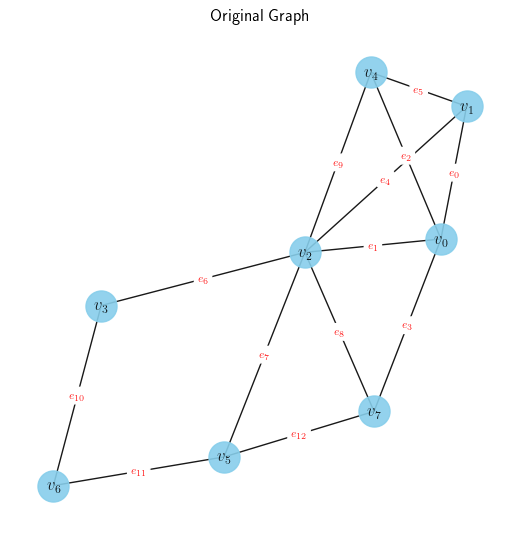

 - Graph with 8 vertices and 13 edges.
 - Features dimensions: [1, 0]
 - There are 0 isolated nodes.



In [3]:
dataset = loader.load()
describe_data(dataset)

In [4]:
type(dataset)

modules.data.utils.custom_dataset.CustomDataset

## Loading and Applying the Lifting

In this section, we will instantiate the lifting we want to apply to the data. In this tutorial, we apply an novel lifting based on  Forman-Ricci curvature. In general, curvature is a geometric property that describes the local shape of an object. In the graph, an edge with positive curvature represents an edge within a cluster, while a negative curvature edge tents to be a bridge within clusters.  Forman-Ricci curvature defines an edge-based network characteristic that reveals properties of a graph's community structure [1,2]. In particular high absolute Forman-Ricci curvature exhibits a network's backbone, a coarse, structure preserving graph geometry that forms connections between major communities, most suitable to form hyperedges. In addition, Forman-Ricci curvature was found to be especially useful for network analysis since its intuitive notion allows for efficient computation that scales to large networks sizes.

Network representations of relational data $G = {V (G), E(G)}$ form regular, 1-dimensional cell complexes, in which case the following curvature function can be defined:

${\rm Ric_F}(e) = \omega (e) \left( \frac{\omega (v_1)}{\omega (e)} +  \frac{\omega (v_2)}{\omega (e)}  - \sum_{\substack{e_{v_1}\ \sim\ e \\ \ e_{v_2}\ \sim\ e}} \left[\frac{\omega (v_1)}{\sqrt{\omega (e) \omega (e_{v_1})}} + \frac{\omega (v_2)}{\sqrt{\omega (e) \omega (e_{v_2})}} \right] \right)\,.$

The function is defined on each edge $e = (v_1, v_2) \in E(G)$ of the network, connecting vertices $v_1, v_2 \in V (G)$; $\omega$ denotes the weights of edges and vertices. Our approach is applicable to both weighted and unweighted networks. In case of unweighted networks all weights in the above equation reduce to 1, i.e. $\omega (e) = \omega (v_1) = \omega (v_2) = 1$.

Our approach is straightforward: (1) calculate the Forman-Ricci curvature over the edges of a graph, (2) from the given distribution of curvature weights, either define an absolute threshold on Forman-Ricci curvature or give a quantile for automatic, network-dependent threshold estimation for backbone extraction, (3) prune the curvature graph using this threshold (4) identify and add remaining network backbone geometries as hyperedges to lift the original graph.


***
[[1]](https://arxiv.org/pdf/1607.08654) Melanie Weber, Emil Saucan, Jürgen Jost, Characterizing complex networks with Forman-Ricci curvature and associated geometric flows, Journal of Complex Networks, Volume 5, Issue 4, August 2017, Pages 527–550.

[[2]](https://web.math.princeton.edu/~mw25/project/files/NIPS-FR.pdf) M. Weber, J. Jost, E. Saucan (2018). Detecting the Coarse Geometry of Networks. NeurIPS R2L.

***

For hypergraphs, creating a lifting involves creating the `incidence_hyperedges` matrix.

Similarly to before, we can specify the transformation we want to apply through its type and id --the corresponding config files located at `/configs/transforms.` 

Note that the *tranform_config* dictionary generated below can contain a sequence of transforms if it is needed.

This can also be used to explore liftings from one topological domain to another; for example, using two liftings, it is possible to achieve a sequence such as graph -> simplicial complex -> hypergraph. 

In [5]:
# Define transformation type and id
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "graph2hypergraph/forman_ricci_curvature_lifting"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}


Transform configuration for graph2hypergraph/forman_ricci_curvature_lifting:

{'transform_type': 'lifting',
 'transform_name': 'HypergraphFormanRicciCurvatureLifting',
 'network_type': 'weighted',
 'threshold_type': 'quantile',
 'threshold_direction': 'upper',
 'threshold': 0.1,
 'feature_lifting': 'ProjectionSum'}


We than apply the transform via our `PreProcessor`:

In [6]:
# transform_config["lifting"]["threshold_type"] = "absolute"
# transform_config["lifting"]["threshold"] = -1
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)

Processing...
Done!



Dataset only contains 1 sample:


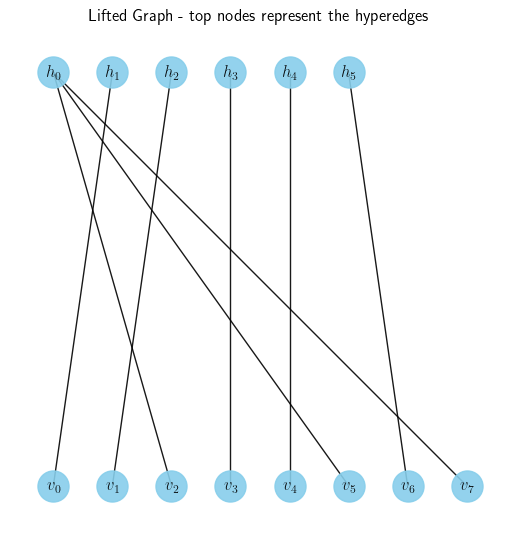

 - Hypergraph with 8 vertices and 6 hyperedges.
 - The nodes have feature dimensions 1.
 - The hyperedges have feature dimensions 1.



In [7]:
describe_data(lifted_dataset)

Given the automated quantile based threshold estimation, the algorithm collapses nodes adjacent to edges with the most significant curvature absolute values based on the given very low quantile (default: 0.1).

## Create and Run a Simplicial NN Model

In this section a simple model is created to test that the used lifting works as intended. In this case the model uses the `incidence_hyperedges` matrix so the lifting should make sure to add it to the data.

In [8]:
from modules.models.hypergraph.unigcn import UniGCNModel

model_type = "hypergraph"
model_id = "unigcn"
model_config = load_model_config(model_type, model_id)

model = UniGCNModel(model_config, dataset_config)


Model configuration for hypergraph UNIGCN:

{'in_channels': None,
 'hidden_channels': 32,
 'out_channels': None,
 'n_layers': 2}


In [9]:
y_hat = model(lifted_dataset.get(0))

If everything is correct the cell above should execute without errors. 

Let's try another example, i.e. chemical structures from the MUTAG dataset, where node an edge features are > 1, hence the algorithm switches to the unweighted version automatically. Further, we change the configuration to allow for the definition of absolute thresholds on Forman-Ricci curvature to explore the evolution of the hyperedge geometry.

In [10]:
dataset_name = "MUTAG"
dataset_config = load_dataset_config(dataset_name)
loader = GraphLoader(dataset_config)


Dataset configuration for MUTAG:

{'data_domain': 'graph',
 'data_type': 'TUDataset',
 'data_name': 'MUTAG',
 'data_dir': 'datasets/graph/TUDataset',
 'num_features': [7, 4],
 'num_classes': 2,
 'task': 'classification',
 'loss_type': 'cross_entropy',
 'monitor_metric': 'accuracy',
 'task_level': 'graph',
 'max_dim_if_lifted': 2,
 'preserve_edge_attr_if_lifted': False}



Dataset contains 188 samples.

Providing more details about sample 0/188:


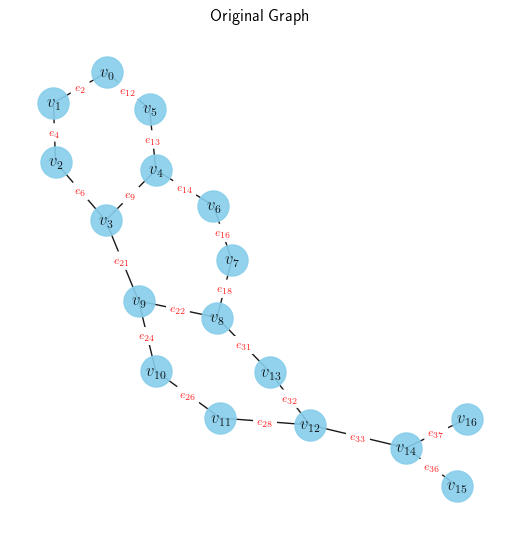

 - Graph with 17 vertices and 38 edges.
 - Features dimensions: [7, 4]
 - There are 0 isolated nodes.



In [11]:
dataset = loader.load()
describe_data(dataset)

The Forman-Ricci curvature for this molecular structure is rather small in absolute values ranging from -2 to 0. Hence we can nicely control the creation of hyperedges, using absolute tresholds. 

Transform parameters are the same, using existing data_dir: /Users/michael/perelyn/research/topological_deep_learning/challenge-icml-2024/datasets/graph/TUDataset/MUTAG/lifting/1661761690

Dataset contains 188 samples.

Providing more details about sample 0/188:


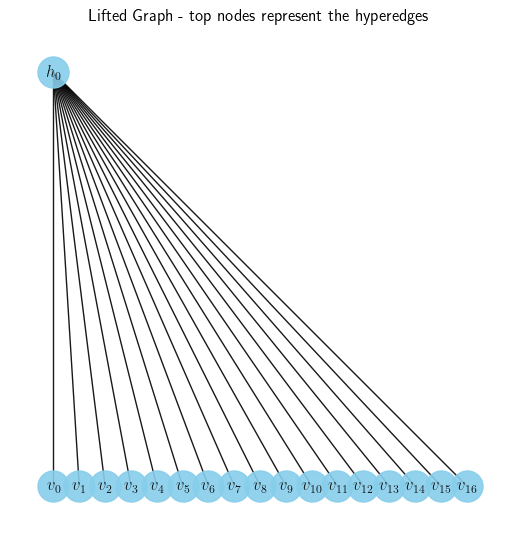

 - Hypergraph with 17 vertices and 1 hyperedges.
 - The nodes have feature dimensions 7.
 - The hyperedges have feature dimensions 7.



In [12]:
transform_config["lifting"]["threshold_type"] = "absolute"
transform_config["lifting"]["threshold"] = 0
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset)

For an absolute threshold of 0, no edge of the Forman-Ricci curvature graph is pruned, and hence the whole curvature graph forms a single hyperedge

Transform parameters are the same, using existing data_dir: /Users/michael/perelyn/research/topological_deep_learning/challenge-icml-2024/datasets/graph/TUDataset/MUTAG/lifting/1394719298

Dataset contains 188 samples.

Providing more details about sample 0/188:


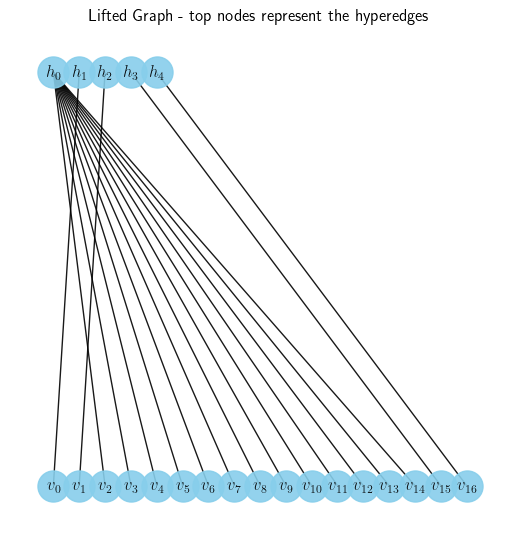

 - Hypergraph with 17 vertices and 5 hyperedges.
 - The nodes have feature dimensions 7.
 - The hyperedges have feature dimensions 7.



In [13]:
transform_config["lifting"]["threshold_type"] = "absolute"
transform_config["lifting"]["threshold"] = -1
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset)

Setting the absolute thresholds to -1 and -2 respectively we see the emergence of multiple smaller hyperedges forming.

Transform parameters are the same, using existing data_dir: /Users/michael/perelyn/research/topological_deep_learning/challenge-icml-2024/datasets/graph/TUDataset/MUTAG/lifting/2879822529

Dataset contains 188 samples.

Providing more details about sample 0/188:


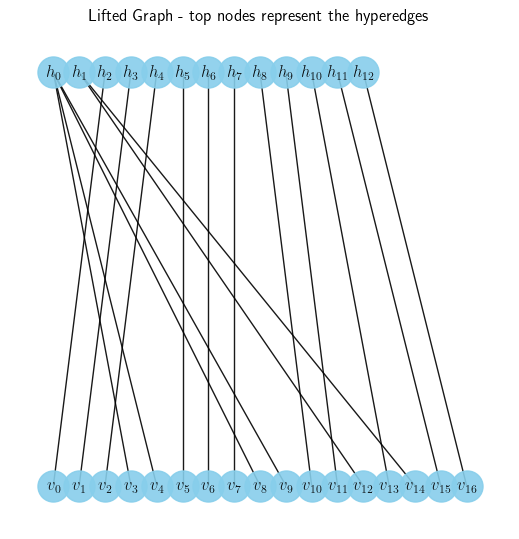

 - Hypergraph with 17 vertices and 13 hyperedges.
 - The nodes have feature dimensions 7.
 - The hyperedges have feature dimensions 7.



In [16]:
transform_config["lifting"]["threshold_type"] = "absolute"
transform_config["lifting"]["threshold"] = -2
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset)